In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import csv
from sklearn.model_selection import train_test_split

from envs.createEnvs import createCSVEnv

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
env = createCSVEnv()

In [3]:
# Nombre del archivo CSV
input_csv = '../data/csv/history14x14.csv'
output_csv = '../data/csv/new14x14.csv'

# Listas para almacenar los valores de las columnas 's' y 'reward'
sy_values = []
sx_values = []
a_values = []
sy1_values = []
sx1_values = []
reward_values = []

In [4]:
"""# Create a set to store unique rows
unique_rows = set()

# Leer el archivo CSV y encontrar filas únicas
with open(input_csv, 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    header = next(csv_reader)  # Leer la fila de encabezado
    output_rows = [header]  # Lista para almacenar las filas de salida, incluida la fila de encabezado

    for row in csv_reader:
        # Verificar si el valor de la columna "done" es igual a "True"
        if row[7].strip().lower() == 'true':
            # Agregar la fila a las filas de salida
            output_rows.append(row)
        else:
            # Eliminar la columna "step" (la primera columna) antes de verificar duplicados
            row_no_step = row[1:]
            # Convertir la fila a una cadena para verificar duplicados
            row_str = ",".join(row_no_step)
            # Verificar si la fila ya existe en el conjunto de filas únicas
            if row_str not in unique_rows:
                unique_rows.add(row_str)
                # Agregar la fila a las filas de salida
                output_rows.append(row)

# Escribir las filas únicas en el archivo CSV de salida
with open(output_csv, 'w', newline='') as csv_output:
    csv_writer = csv.writer(csv_output)
    csv_writer.writerows(output_rows)"""

'# Create a set to store unique rows\nunique_rows = set()\n\n# Leer el archivo CSV y encontrar filas únicas\nwith open(input_csv, \'r\') as csv_file:\n    csv_reader = csv.reader(csv_file)\n    header = next(csv_reader)  # Leer la fila de encabezado\n    output_rows = [header]  # Lista para almacenar las filas de salida, incluida la fila de encabezado\n\n    for row in csv_reader:\n        # Verificar si el valor de la columna "done" es igual a "True"\n        if row[7].strip().lower() == \'true\':\n            # Agregar la fila a las filas de salida\n            output_rows.append(row)\n        else:\n            # Eliminar la columna "step" (la primera columna) antes de verificar duplicados\n            row_no_step = row[1:]\n            # Convertir la fila a una cadena para verificar duplicados\n            row_str = ",".join(row_no_step)\n            # Verificar si la fila ya existe en el conjunto de filas únicas\n            if row_str not in unique_rows:\n                unique_r

In [5]:
row_counts = {}
max_duplicates=4

# Leer el archivo CSV y encontrar filas únicas
with open(input_csv, 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    header = next(csv_reader)  # Leer la fila de encabezado
    output_rows = [header]  # Lista para almacenar las filas de salida, incluida la fila de encabezado

    for row in csv_reader:
        # Eliminar la columna "step" (la primera columna) antes de verificar duplicados
        row_no_step = row[1:]
        # Convertir la fila a una cadena para verificar duplicados
        row_str = ",".join(row_no_step)
        # Contar cuántas veces aparece la fila
        if row_str not in row_counts:
            row_counts[row_str] = 1
        else:
            row_counts[row_str] += 1
        # Verificar si la fila aparece menos o igual al número máximo de veces permitidas
        if row_counts[row_str] <= max_duplicates:
            # Agregar la fila a las filas de salida
            output_rows.append(row)

# Escribir las filas únicas en el archivo CSV de salida
with open(output_csv, 'w', newline='') as csv_output:
    csv_writer = csv.writer(csv_output)
    csv_writer.writerows(output_rows)

In [6]:
# Leer el archivo CSV
with open(output_csv, 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    next(csv_reader)  # Quitar la primera fila donde están los nombres de las columnas

    for row in csv_reader:
        step, y, x, action, next_y, next_x, reward, done =  row
        sy_values.append(float(y))
        sx_values.append(float(x))
        a_values.append(float(action))
        sy1_values.append(float(next_y))
        sx1_values.append(float(next_x))
        reward_values.append(float(reward))

In [7]:
# Convertir las listas en NumPy arrays
sy_array = np.array(sy_values)
sx_array = np.array(sx_values)
a_array = np.array(a_values)
sy1_array = np.array(sy1_values)
sx1_array = np.array(sx1_values)
reward_array = np.array(reward_values)

In [8]:
input_data1 = np.column_stack((sy_array, sx_array, a_array))
target_data1 = np.column_stack((sy1_array, sx1_array))
input_data2 = input_data1
target_data2 = reward_array

In [9]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(input_data1, target_data1, test_size=0.2, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(input_data2, target_data2, test_size=0.2, random_state=42)

In [10]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, fc1_unit, fc2_unit, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, fc1_unit)
        self.fc2 = nn.Linear(fc1_unit, fc2_unit)
        self.fc3 = nn.Linear(fc2_unit, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [11]:
# Create an instance of the model
model1 = NeuralNetwork(3, 256, 128, 2)
model2 = NeuralNetwork(3, 64, 64, 1)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer1 = optim.Adam(model1.parameters())
optimizer2 = optim.Adam(model2.parameters())

In [12]:
# Convert NumPy arrays to PyTorch tensors
X_train_tensor1 = torch.tensor(X_train1, dtype=torch.float32)
y_train_tensor1 = torch.tensor(y_train1, dtype=torch.float32)
X_test_tensor1 = torch.tensor(X_test1, dtype=torch.float32)
y_test_tensor1 = torch.tensor(y_test1, dtype=torch.float32)

X_train_tensor2 = torch.tensor(X_train2, dtype=torch.float32)
y_train_tensor2 = torch.tensor(y_train2, dtype=torch.float32).view(-1, 1)  # Reshape the target tensor
X_test_tensor2 = torch.tensor(X_test2, dtype=torch.float32)
y_test_tensor2 = torch.tensor(y_test2, dtype=torch.float32).view(-1, 1)  # Reshape the target tensor

In [13]:
num_epochs1 = 500000
losses1 = []

for epoch in range(num_epochs1):
    # Forward pass
    outputs = model1(X_train_tensor1)
    loss = criterion(outputs, y_train_tensor1)
    
    # Backpropagation and optimization
    optimizer1.zero_grad()
    loss.backward()
    optimizer1.step()
    
    losses1.append(loss.item())

print("Modelo entrenado!")

Modelo entrenado!


In [14]:
# Evaluate the model on the test data
with torch.no_grad():
    test_outputs = model1(X_test_tensor1)
    test_loss = criterion(test_outputs, y_test_tensor1)
    print(f'Test loss: {test_loss.item()}')

Test loss: 2.2301203443930717e-06


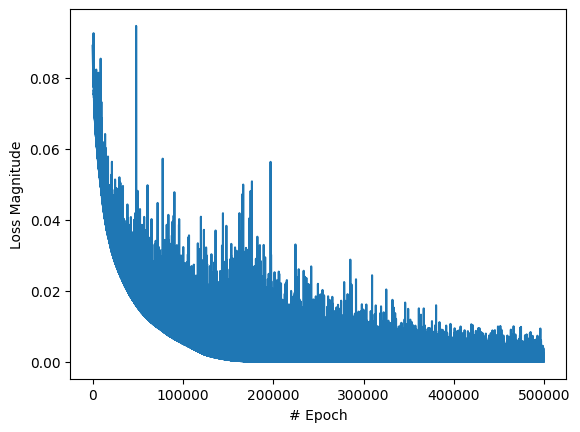

In [15]:
# Plot the training loss
plt.xlabel("# Epoch")
plt.ylabel("Loss Magnitude")
plt.plot(losses1[1000:])

In [16]:
# Perform predictions
grid = np.chararray((14,14), unicode=True)
for j in range(14):
    for k in range(14):
        for i in range(4):
            env_result = env.test([j, k, i])
            if type(env_result) == str:
                grid[j][k] = "#"
            else:
                grid[j][k] = "."
                test_input = torch.tensor([[float(j), float(k), float(i)]], dtype=torch.float32)
                resultado = model1(test_input)
                resultado = resultado.detach().numpy()
                if not(env_result[0] == round(resultado[0][0]) and env_result[1] == round(resultado[0][1])):
                    print([j, k, i])
                    print("El resultado es " + str(env_result))
                    print("El resultado es [" + str(round(resultado[0][0])) + " " + str(round(resultado[0][1])) + "]\n")


[0, 13, 2]
El resultado es [ 0 12]
El resultado es [0 13]

[0, 13, 3]
El resultado es [ 0 13]
El resultado es [0 14]



c:\Users\el_sa\anaconda3\envs\TFG\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.test to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.test` for environment variables or `env.get_wrapper_attr('test')` that will search the reminding wrappers.
  logger.warn(


In [17]:
torch.save(model1.state_dict(), '../data/models/modelo_entorno.pt')
#El nombre empieza con _ para no sobreescribir los modelos ya creados

Red para modelar la función de recompensa:

In [18]:
num_epochs2 = 3000
losses2 = []

for epoch in range(num_epochs2):
    # Forward pass
    outputs = model2(X_train_tensor2)
    loss = criterion(outputs, y_train_tensor2)
    
    # Backpropagation and optimization
    optimizer2.zero_grad()
    loss.backward()
    optimizer2.step()
    
    losses2.append(loss.item())

print("Modelo entrenado!")

Modelo entrenado!


In [19]:
# Evaluate the model on the test data
with torch.no_grad():
    test_outputs = model2(X_test_tensor2)
    test_loss = criterion(test_outputs, y_test_tensor2)
    print(f'Test loss: {test_loss.item()}')

Test loss: 1.9952343791374005e-05


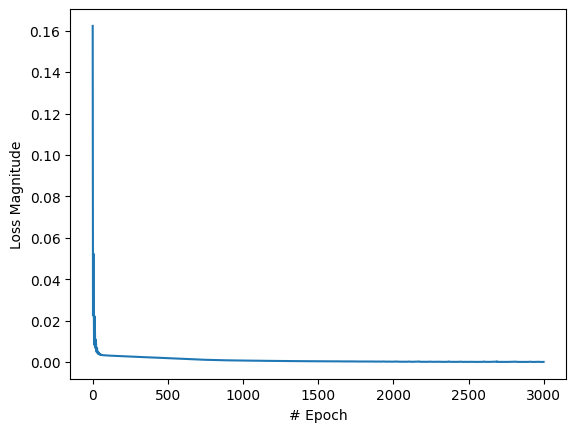

In [20]:
# Plot the training loss
plt.xlabel("# Epoch")
plt.ylabel("Loss Magnitude")
plt.plot(losses2)

In [21]:
# Perform predictions
for j in range(14):
    for k in range(14):
        for i in range(4):
            test_input = torch.tensor([[float(j), float(k), float(i)]], dtype=torch.float32)
            resultado = model2(test_input)
            resultado = resultado.detach().numpy()
            #print("El vector de entrada [y,x,a] es ", [j, k, i])
            #print("El resultado es " + str(resultado[0][0]) + " \t-> Redondeo: " + str(round(resultado[0][0])))
            if round(resultado[0][0]) == 1:
                print(str([j, k, i]) + "\t->\t" + str(round(abs(resultado[0][0]), 4)) + " \t-> Redondeo: " + str(round(resultado[0][0])))


[0, 11, 3]	->	0.6821 	-> Redondeo: 1
[0, 12, 3]	->	0.9941 	-> Redondeo: 1
[0, 13, 3]	->	1.1451 	-> Redondeo: 1
[1, 13, 0]	->	0.9782 	-> Redondeo: 1


In [22]:
#torch.save(model2.state_dict(), '../data/models/modelo_reward.pt')
#El nombre empieza con _ para no sobreescribir los modelos ya creados